# CSI 6160 Homework 6
### Samantha Bracellari & Justin Kur

For this assignment, we used the iris dataset that can be found in the [UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/iris). This dataset has 150 samples and the following features:

1. sepal length in cm 
2. sepal width in cm 
3. petal length in cm 
4. petal width in cm  
5. class:
   - Iris Setosa 
   - Iris Versicolour 
   - Iris Virginica

We perform stratified 5-fold cross validation and split the data into train and test sets. 80% of the data will be used for training, while the remaining 20% will be used for testing. We're using stratified k-fold for this assignment to make the ratio of positive and negative classes consistent in each split.

We also pass an optional dimension parameter while retrieving the data. This indicates whether or not we use PCA on the data to reduce its dimensionality down to 2D. This is done mainly for visualization purposes.

Lastly, we add an additional column to the data that represents the class as an int (0 for setosa, 1 for versicolor, and 2 for virginica). Doing so will ensure that our predictions are in line with the true labels; otherwise, the model may take unnecessary hits on its accuracy.

In [1]:
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
import polars as pl

TARGET = 'Label_Int'
CLUSTERS = 3

def fetch_data(df, use_split, dim=4):
    assert(use_split >= 0 and use_split <= 4)
    # perform 5-fold cross validation with a deterministic seed
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2028)
    split_x, split_y = get_x_y(df)
    splits = list(kf.split(split_x, split_y))

    # indexing the dataframe with an array returns the appropriate splits
    df_train, df_test = df[splits[use_split][0]], df[splits[use_split][1]]
    if dim < 4:
        pca = PCA(n_components=dim)
        
        train = df_train.select([f"column_{i+1}" for i in range(4)]).to_numpy()
        train = pca.fit_transform(train)
        test = df_test.select([f"column_{i+1}" for i in range(4)]).to_numpy()
        test = pca.transform(test)
        for i in range(dim):
            series = pl.Series(f"column_{i+1}", train[:, i])
            df_train = df_train.with_columns(series)
            series = pl.Series(f"column_{i+1}", test[:, i])
            df_test = df_test.with_columns(series)
        for i in range(dim, 4):
            df_train = df_train.drop(f"column_{i+1}")
            df_test = df_test.drop(f"column_{i+1}")
    return df_train, df_test

def get_x_y(df):
    df = df.drop("Label")
    X, y = df.drop(TARGET).to_numpy(), df.get_column(TARGET)
    return X, y.to_numpy()

df = pl.read_csv('iris.data', has_header=False)
df = df.rename({"column_5": "Label"})
df = df.with_columns(pl.col("Label").cast(pl.Categorical).to_physical().alias(TARGET))
df_train, df_test = fetch_data(df, 0)
X_train, y_train = get_x_y(df_train)
X_test, y_test = get_x_y(df_test)
df_train.tail()

column_1,column_2,column_3,column_4,Label,Label_Int
f64,f64,f64,f64,str,u32
6.8,3.2,5.9,2.3,"""Iris-virginica...",2
6.7,3.3,5.7,2.5,"""Iris-virginica...",2
6.7,3.0,5.2,2.3,"""Iris-virginica...",2
6.5,3.0,5.2,2.0,"""Iris-virginica...",2
6.2,3.4,5.4,2.3,"""Iris-virginica...",2


In [2]:
ID_TO_NAME = {}
NAME_TO_ID = {}
for p in df.partition_by("Label"):
    label = p.row(0)[-2]
    id = p.row(0)[-1]
    ID_TO_NAME[id] = label
    NAME_TO_ID[label] = id
ID_TO_NAME

{0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}

### Benchmarking

As per usual, we begin by setting a baseline with sklearn. Using the default parameters & 10 centroid initializations, sklearn is able to predict the correct iris class roughly 87% of the time.

Our accuracy metric is straightforward this time. We simply measure the ratio of correct predictions to total test samples.

In [3]:
from sklearn.cluster import KMeans
import numpy as np

model = KMeans(n_clusters=CLUSTERS, random_state=2028, n_init=10)
model.fit(X_train)

preds = model.predict(X_test)
np.count_nonzero(preds == y_test) / len(y_test)

0.8666666666666667

### Our K-Means

Our implementation of K-Means is on par with sklearn, also predicting the correct label about 87% of the time. This equates to 4 misclassified examples in total for the test set.

To remain in-line with sklearn, we adapt our model to accept an `n_init` parameter, so that we have a better chance at reaching near-optimal centroid initialization. Additionally, we also initialize centroids using the kmeans++ method, which can be described as follows:

1. initialize the first centroid randomly
2. compute all distances from the data points to the selected centroid, and choose the farthest distance $x$
3. make the point $x$ as the new centroid that has the maximum probability proportional to the farthest distance
4. repeat steps 2 & 3 until all centroids are chosen

In [4]:
import numpy as np
from numpy.random import Generator, PCG64

def euclidean(p1, p2):
    return np.sqrt(np.sum((p1 - p2)**2, axis=1))

# for each point, find the closest centroid & assign to a cluster
def assign_clusters(X, centroids):
    return [np.argmin(euclidean(x, centroids)) for x in X]

def score_clusters(X, centroids):
    return sum([np.min(euclidean(x, centroids)) for x in X])
    
# update the centroids
def update_centroids(X, clusters):
    centroids = []

    for c in set(clusters):
        cluster = X[np.where(clusters == c)[0]]
        mean = cluster.mean(axis=0)
        centroids.append(mean)
    return centroids

# initialize centroids using kmeans++ method
def initialize_centroids(X, n_clusters, seed):
    # randomly initialize one centroid.
    gen = Generator(PCG64(seed=seed))
    centroids = [gen.choice(X_train)]

    for _ in range(n_clusters - 1):
        distances = np.sum([euclidean(X_train, centroid) for centroid in centroids], axis=0)            
        distances /= np.sum(distances) # normalize

        # choose centroids probabilistically based on distance
        centroid_idx = gen.choice(range(len(X_train)), size=1, p=distances)[0]
        centroids += [X_train[centroid_idx]]
    return centroids

class K_Means():
    def __init__(self, n_clusters, epochs=350, seed=482023, n_init=10):
        self.n_clusters = n_clusters
        self.epochs = epochs
        self.centroids = []
        self.seed = seed
        self.n_init = n_init

    def fit(self, X):
        self.centroids = initialize_centroids(X, self.n_clusters, self.seed)
        best_score = 1e10
        epsilon = 1e-4
        # Following sklearn, perform multiple initializations, choose the best based on total distance from cluster centers
        for init in range(self.n_init):
            centroids = initialize_centroids(X, self.n_clusters, self.seed + init)
            clusters = assign_clusters(X, centroids)
            centroids = update_centroids(X, clusters)
            last_score = 1e10
            for _ in range(self.epochs):
                clusters = assign_clusters(X, centroids)
                centroids = update_centroids(X, clusters)
                score = score_clusters(X, centroids)
                # Abort early if clusters do not change
                if abs(score - last_score) < epsilon:
                    break
                last_score = score 
            if score < best_score:
                self.centroids = centroids
                self.clusters = clusters
            
    
    def predict(self, X):
        return np.array(assign_clusters(X, self.centroids))
    
def reassign(preds, actual):
    '''Map each cluster to its majority label in the data, correcting arbitrary label values'''
    assignment = np.zeros_like(preds)
    for i in range(CLUSTERS):
        # Select real labels of cluster
        select = actual[(preds == i).nonzero()]
        # Return mode
        mode = 0
        mode_count = -1
        for c in range(CLUSTERS):
            total = (select == c).sum()
            if total > mode_count:
                mode_count = total 
                mode = c
        assignment[(preds == i).nonzero()] = mode
    return assignment

model = K_Means(n_clusters=CLUSTERS) 
model.fit(X_train)

preds = model.predict(X_test)
preds = reassign(preds, y_test)
np.count_nonzero(preds == y_test) / len(y_test)

0.8666666666666667

In [5]:
def run_experiment(df, use_split):
    df_train, df_test = fetch_data(df, use_split)
    X_train, _ = get_x_y(df_train)
    X_test, y_test = get_x_y(df_test)
    model = K_Means(n_clusters=CLUSTERS) 
    model.fit(X_train) 
    preds = model.predict(X_test)
    preds = reassign(preds, y_test)
    return len(y_test) - np.count_nonzero(preds == y_test)

def sk_bench(df, use_split):
    df_train, df_test = fetch_data(df, use_split)
    X_train, _ = get_x_y(df_train)
    X_test, y_test = get_x_y(df_test)
    model = KMeans(n_clusters=CLUSTERS, random_state=2028, n_init=10)
    model.fit(X_train)
    preds = model.predict(X_test)
    preds = reassign(preds, y_test)
    return len(y_test) - np.count_nonzero(preds == y_test)

### Evaluation

We check the misclassification on a 5-fold cross validation split. We see our values line up very closely with sklearn, and are well beneath the threshold of 7 misclassified examples specified by the assignment. 

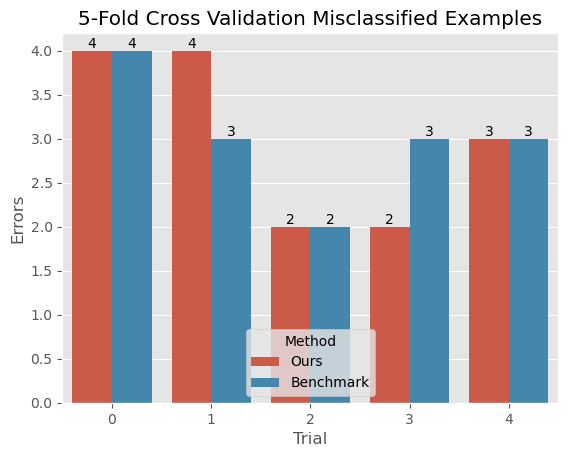

In [6]:
import seaborn
import pandas as pd 
import matplotlib.pyplot as plt

plt.style.use('ggplot')
COLORS = seaborn.color_palette()
f, ax = plt.subplots()

our_method = [run_experiment(df, x) for x in range(5)]
benchmark = [sk_bench(df, x) for x in range(5)]
method = ['Ours' for _ in range(5)] + ['Benchmark' for _ in range(5)]
plot_df = pd.DataFrame.from_dict({'Errors': our_method + benchmark, 'Method': method, 'Trial': list(range(5)) + list(range(5))})
ax.set_title('5-Fold Cross Validation Misclassified Examples')
seaborn.barplot(data=plot_df, x='Trial', y='Errors', hue='Method', ax=ax, palette=COLORS)
seaborn.move_legend(ax, "lower center")
for container in ax.containers:
    ax.bar_label(container)

Below, we visualize the clustering by projecting the original data into 2 dimensions. We can see that even though the information from 2 out 4 dimensions is lost the cluster centers are close to what we would visually expect, and the groups are relatively homogeneous, although in the bottom right there is some mixing between two of the cluster groups. In higher dimensions, these two clusters will be more cleanly partitioned.

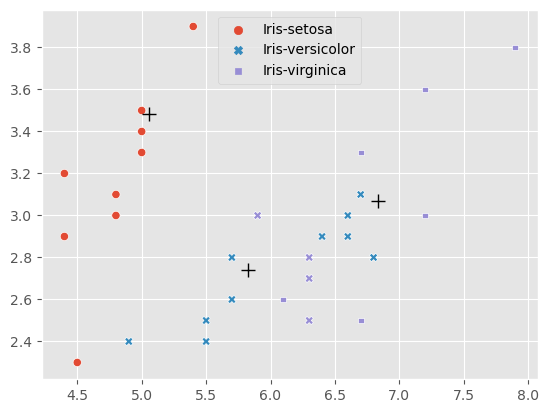

In [7]:
import seaborn 
import matplotlib.pyplot as plt

plt.style.use('ggplot')
COLORS = seaborn.color_palette()

plt.figure()
ax = seaborn.scatterplot(
    x=[X[0] for X in X_test], y=[X[1] for X in X_test], hue=y_test,
    style=preds, palette=COLORS[0:3], legend='full')
plt.plot(
    [x for x, _, _, _ in model.centroids], [y for _, y, _, _ in model.centroids], '+',
    markersize=10, c='black')
h, _ = ax.get_legend_handles_labels()
labels = [ID_TO_NAME[x] for x in range(3)]
plt.legend(handles=h, loc='upper center', labels=labels)
plt.show()

## Gaussian Mixture Model
We open by benchmarking the sklearn Gaussian Mixture Model (GMM). We can see on this split of the data sklearn successfully achieves quite similar mixing coefficients, meaning we should expect our implementation to achieve the same 

We follow the GMM formulation in the provided slides, using means and full covariance initialized by our kmeans clustering implementation. The 3 mixing coefficients are all initialized to 1/3. 

In [8]:
from sklearn.mixture import GaussianMixture
df_train, df_test = fetch_data(df, 1)
X_train, y_train = get_x_y(df_train)
X_test, y_test = get_x_y(df_test)
mix = GaussianMixture(n_components=3, covariance_type="full")
mix.fit(X_train, y_train)
mix_preds = mix.predict(X_test)
mix_preds = reassign(mix_preds, y_test)
np.count_nonzero(mix_preds == y_test) / len(y_test)
mix.weights_

array([0.30992451, 0.33333333, 0.35674215])

In [9]:
def normal_pdf(x, mu, sigma):
    '''Calculate the pdf of the multivariate normal distribution N(x | μ, Σ)'''
    k = len(mu)
    # Assume x, mu are row vectors 
    denom1 = np.sqrt((2 * np.pi)**k * np.linalg.det(sigma))
    mat1 = np.matmul((x - mu).T, np.linalg.inv(sigma)) 
    num1 = np.exp(-0.5 * np.matmul(mat1, (x - mu)))
    return num1 / denom1

class Mixture:
    def __init__(self, mu, sigma, pi):
        self.n_classes = len(mu)
        self.mu = mu 
        self.sigma = sigma
        self.pi = pi

    def fit(self, X, steps=20):
        N = X.shape[0]
        resp = np.zeros((N, self.n_classes))

        for _ in range(steps):

            # E Step
            for i in range(N):
                x = X[i]
                resp[i, :] = self.responsibility(x)
            # M Step
            n_ks = np.sum(resp, axis=0)
            
            # Update Mu
            for k in range(self.n_classes):
                total = np.zeros_like(self.mu[0])
                for i in range(N):
                    total += resp[i, k] * X[i]
                total /= n_ks[k]
                self.mu[k] = total
            # Update Sigma
            for k in range(self.n_classes):
                total = np.zeros_like(self.sigma[0])
                mean = self.mu[k]
                for i in range(N):
                    x = X[i]
                    size = x.size
                    # Reshape the vectors to allow for correct matrix multiplication
                    a = np.reshape(x - mean, (size, 1))
                    b = np.reshape(x - mean, (1, size))
                    val = resp[i, k] * np.matmul(a, b)
                    total += val
                total /= n_ks[k]
                self.sigma[k] = total
            # Update Pi
            self.pi = n_ks / N
        return self.pi
        

    def responsibility(self, x):
        nums = [self.pi[i] * normal_pdf(x, self.mu[i], self.sigma[i]) for i in range(self.n_classes)]
        total = sum(nums)
        return np.array(nums) / total

In [10]:
def run_gmm(X_train, model):
    # Initialize the means to the centroid values
    centroids = [np.copy(x) for x in model.centroids]
    clusters = np.array(model.clusters)
    # Initialize each mixture coefficient with equal weight
    pi = np.ones(3) / 3

    # Initialize the covariance according to the covariance of features within each cluster
    variance = [np.cov(X_train[(clusters == i)].T) for i in range(CLUSTERS)]
    custom_mix = Mixture(centroids, variance, pi)
    custom_coeff = custom_mix.fit(X_train)
    return custom_mix, custom_coeff

_, custom_coeff = run_gmm(X_train, model)
custom_coeff

array([0.33333333, 0.35698147, 0.3096852 ])

[0.35698147 0.33333333 0.3096852 ]


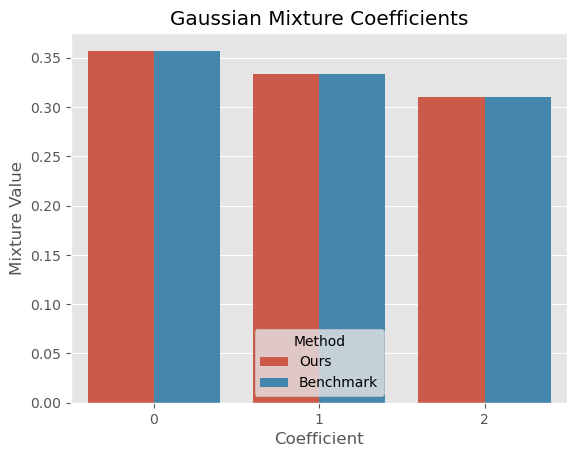

In [11]:
import seaborn
import pandas as pd 
custom_coeff = np.sort(custom_coeff)[::-1]
print(custom_coeff)
sk_weights = np.sort(mix.weights_)
sk_weights = sk_weights[::-1]
plt.style.use('ggplot')
f, ax = plt.subplots()
NUMBER = 3
method = ["Ours" for _ in range(NUMBER)] + ["Benchmark" for _ in range(NUMBER)]
plot_df = pd.DataFrame.from_dict({"Mixture Value": custom_coeff.tolist() + sk_weights.tolist(), 
                                  "Method": method, "Coefficient": list(range(NUMBER)) + list(range(NUMBER))})
ax.set_title("Gaussian Mixture Coefficients")

seaborn.barplot(data=plot_df, x="Coefficient", y="Mixture Value", hue="Method", ax=ax)
seaborn.move_legend(ax, 'lower center')
plt.show()

### Gaussian Mixture Model Visualization

We conclude by visualizing the 3 clusters of the gaussian mixture model in 2 dimensions. In order to do so, we perform PCA at the initial data fetching step using the training split of the data. Then we do the full K_means and GMM training on the 2 dimensional data. In 2D, each cluster can be drawn as an ellipse, with the means determining the center and the variances determining the lengths of both sides of the ellipse. Because the variance is measured in multiple dimensions in the GMM, even without considering the full covariance matrix we are able to construct a relatively complex shape.

In [12]:
# Use reduced dimensionality for visualization 
df_train, df_test = fetch_data(df, 1, dim=2)
X_train, y_train = get_x_y(df_train)
X_test, y_test = get_x_y(df_test)
model = K_Means(n_clusters=CLUSTERS) 
model.fit(X_train)
gmm, custom_coeff = run_gmm(X_train, model)
custom_coeff

array([0.33333333, 0.32491195, 0.34175471])

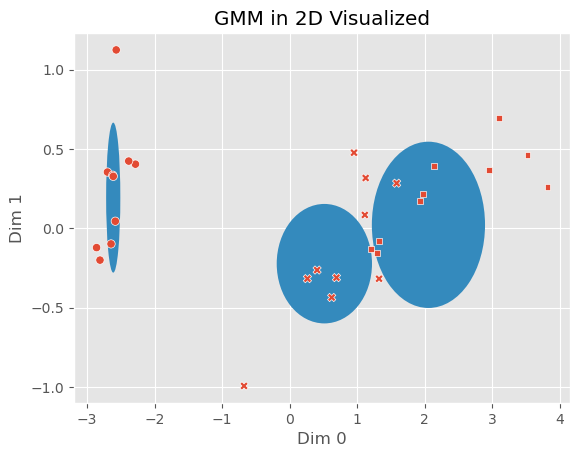

In [13]:
from matplotlib.patches import Ellipse
COLORS = seaborn.color_palette()
f, ax = plt.subplots()
for cl in [0, 1, 2]:
    ax.add_patch(Ellipse((gmm.mu[cl][0], gmm.mu[cl][1]), 4 * gmm.sigma[cl][0][0], 4 * gmm.sigma[cl][1][1], facecolor=COLORS[1]))
seaborn.scatterplot({"x": X_test[:, 0], "y": X_test[:, 1]}, x="x", y="y", style=y_test, ax=ax)
ax.set_ylabel("Dim 1")
ax.set_xlabel("Dim 0")
ax.set_title("GMM in 2D Visualized")
ax.get_legend().remove()
plt.show()